In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from IPython.display import clear_output
import torch

import sys
sys.path.append('../..')

from vae import VAEModel, compute_fid_score
from rbm import RBM
from dbn import DBN
from load_data import load_mnist

# Load data

In [2]:
X_train, y_train, X_test, y_test = load_mnist(binarize=True)

# VAE - Image Generation

In [3]:
PATH = './vae_fid_scores.pkl'

def load_dict(path=PATH):
    with open(path, 'rb') as handle:
        d = pickle.load(handle)
    return d

def save_dict(d, path=PATH):
    with open(path, 'wb') as handle:
        pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
### Load and sort the dictionary of results ###

dict_results = load_dict()
sorted_values = sorted(dict_results.items(), key=lambda item: item[1])  # Sort by the second element (value)
dict_results = dict(sorted_values)

In [5]:
best_parameters = list(dict_results.keys())[0]
beta = float(best_parameters.split(',')[0])
latent_dim = int(best_parameters.split(',')[1])
alpha_lrelu = float(best_parameters.split(',')[2])
print(f'Beta: {beta}, latent dimension: {latent_dim}, leaky_relu scope: {alpha_lrelu}')

Beta: 0.01, latent dimension: 2, leaky_relu scope: 0.2


In [6]:
vae_model = VAEModel(latent_dim=latent_dim, beta=beta, alpha_lrelu=alpha_lrelu)

In [7]:
nb_params_vae = 0
for param in vae_model.parameters():
    nb_params_vae += np.prod(param.size())

print(f"Nb parameters for VAE: {nb_params_vae:,}")

Nb parameters for VAE: 1,068,820


Epoch 0: error = 217.5564
Epoch 10: error = 147.1595
Epoch 20: error = 140.3892
Epoch 30: error = 136.0599
Epoch 40: error = 134.5559
Epoch 50: error = 131.7696
Epoch 60: error = 132.1338
Epoch 70: error = 129.4406
Epoch 80: error = 130.5394
Epoch 90: error = 127.8995
Epoch 100: error = 129.0773
Epoch 110: error = 126.9421
Epoch 120: error = 128.2316
Epoch 130: error = 125.8574
Epoch 140: error = 126.0687
Epoch 150: error = 127.6647
Epoch 160: error = 124.7857
Epoch 170: error = 125.9981
Epoch 180: error = 124.2908
Epoch 190: error = 126.4945
Epoch 200: error = 124.8074
Epoch 210: error = 123.712
Epoch 220: error = 125.4227
Epoch 230: error = 123.4163
Epoch 240: error = 123.0354
Epoch 250: error = 125.0641
Epoch 260: error = 122.3339
Epoch 270: error = 122.6616
Epoch 280: error = 122.8841
Epoch 290: error = 123.2852
##### PATIENCE TRIGGERED!
Epoch 291: error = 122.863


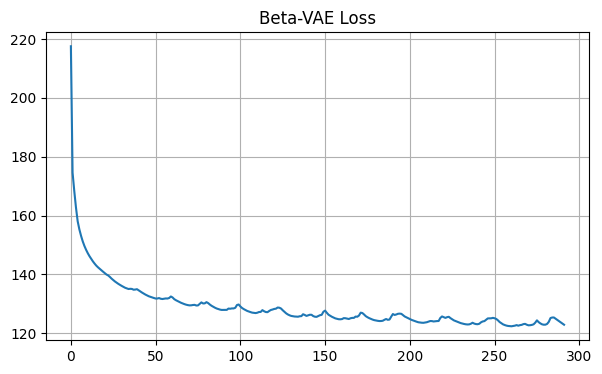

In [8]:
_ = vae_model.train_vae(X_train, 1000, learning_rate=3e-4, batch_size=256, print_error_every=10, patience=30)

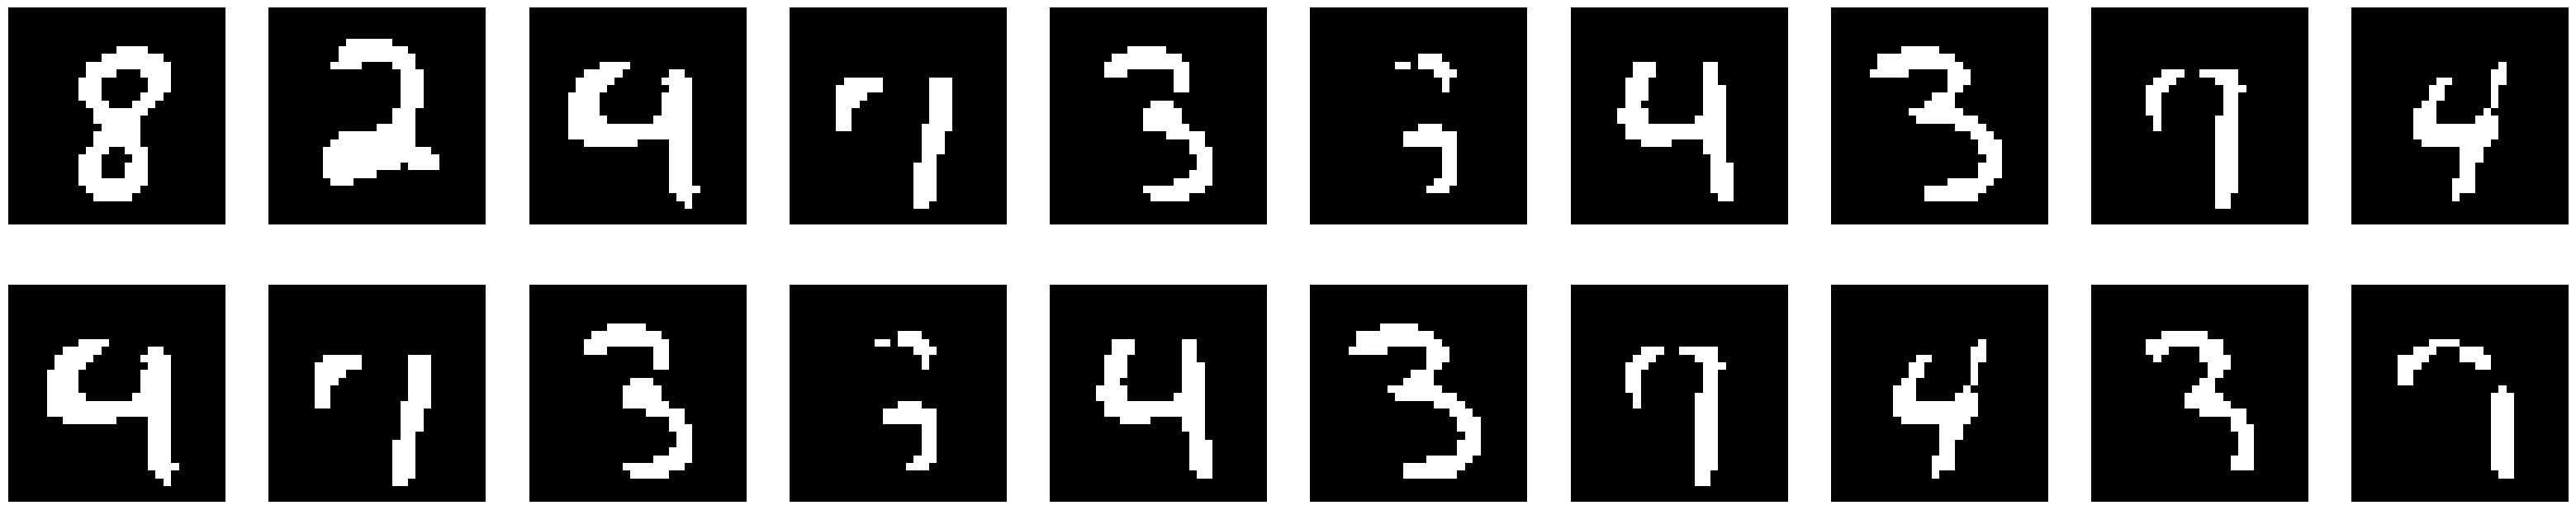

In [21]:
vae_gen = vae_model.generate_data()

In [22]:
vae_fid_score = vae_model.compute_fid_score(X_test[:5000])
print(f"FID score with VAE: {vae_fid_score:.4f}")

# DBN

In [11]:
def compute_params_rbm(rbm):
    return rbm.a.shape[0] + rbm.b.shape[0] + np.prod(rbm.W.shape)

In [12]:
dbn_model = DBN(X=X_train, L=5, qs=[128, 512, 784, 512, 256], use_adam=True)

In [13]:
nb_params_dbn = 0
for rbm in dbn_model.rbms:
    nb_params_dbn += compute_params_rbm(rbm)

print(f"nb parameters for DBN: {nb_params_dbn:,}")

nb parameters for DBN: 1,104,688


In [14]:
try:
    dbn_model.load_weights("./dbn_cmp_vae.pkl")
except:
    dbn_model.train_DBN(epochs=300, learning_rate=3e-4, batch_size=128, print_error_every=10)

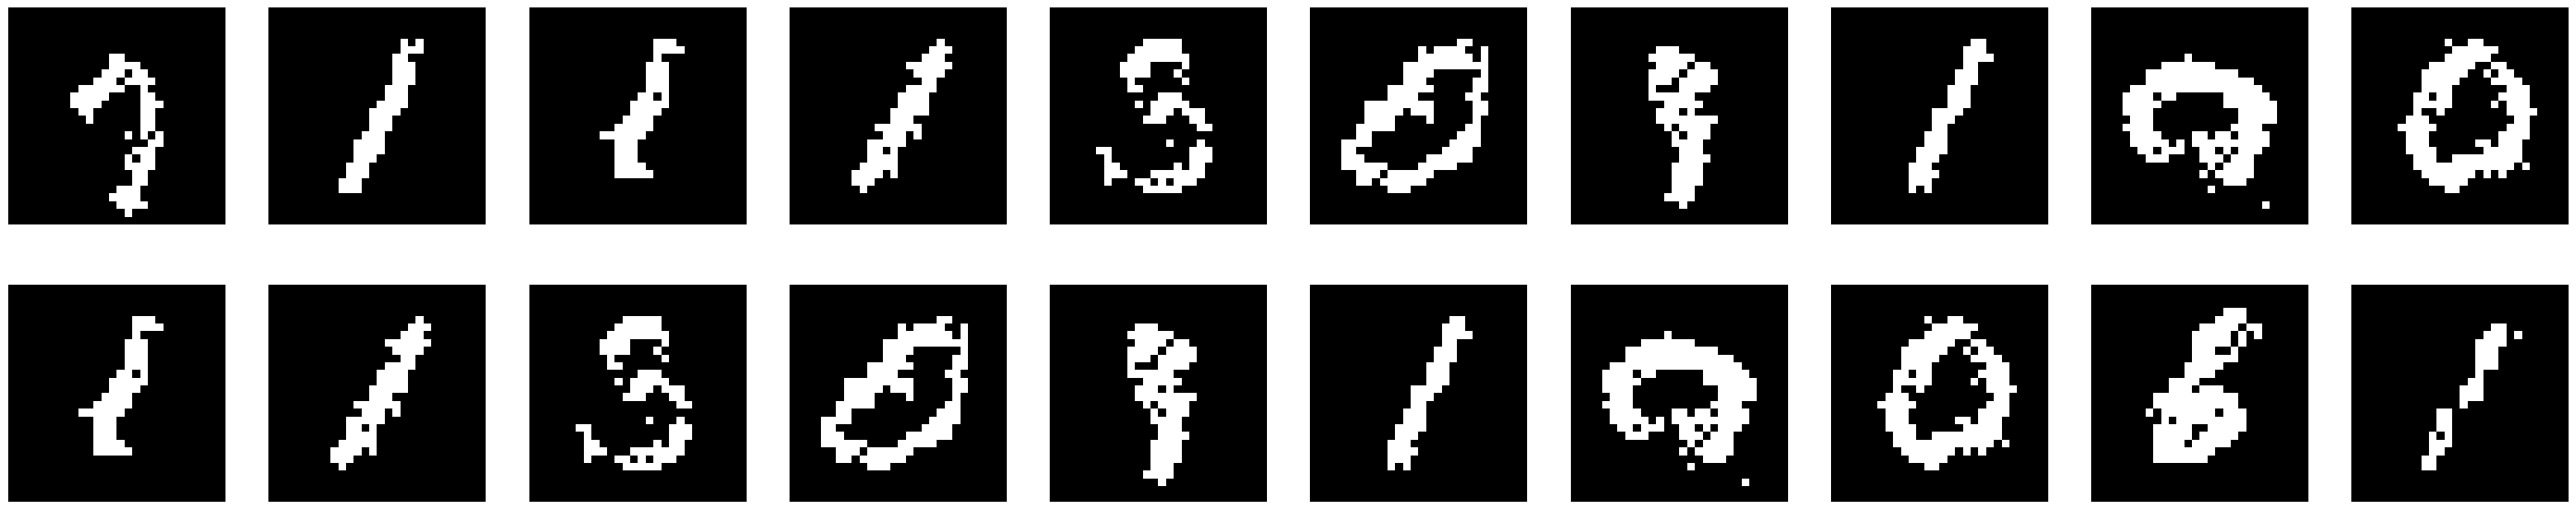

In [15]:
_ = dbn_model.generer_image_DBN(num_samples=20, gibbs_steps=200, ncols=10, image_size=(28, 28))

In [16]:
dbn_generated_images = dbn_model.generer_image_DBN(num_samples=len(X_test[:5000]), gibbs_steps=200, plot_=False)
dbn_fid_score = compute_fid_score(X_test[:5000], dbn_generated_images, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(f"FID score with DBN: {dbn_fid_score:.4f}")

FID score with DBN: 965.4677


In [7]:
dbn_model.save_weights(path='./dbn_cmp_vae')

# RBM

In [17]:
rbm_model = RBM(X=X_train, q=784+512+128, use_adam=True)

nb_params_rbm = compute_params_rbm(rbm_model)
print(f"nb parameters for RBM: {nb_params_rbm:,}")

nb parameters for RBM: 1,118,624


In [18]:
try:
    rbm_model.load_weights("./rbm_cmp_vae.pkl")
except:
    _ = rbm_model.train_RBM(300, learning_rate=3e-4, batch_size=256, plot_errors=True, print_error_every=10)

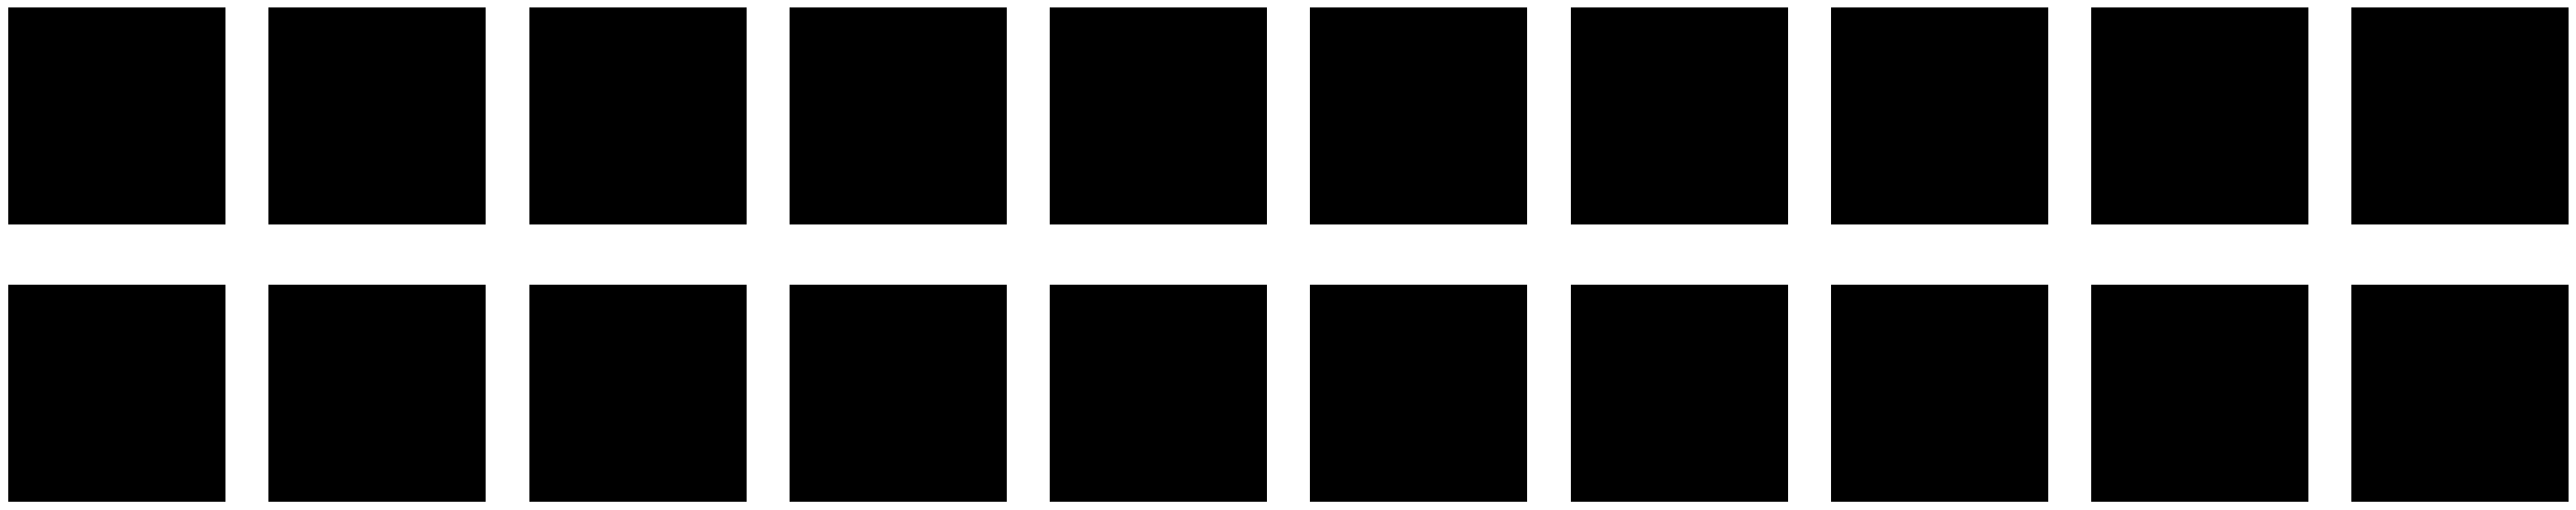

In [19]:
_ = rbm_model.generer_image_RBM(nb_step_gibbs=200, nb_to_generate=20, ncols=10, image_size=(28, 28))

In [20]:
rbm_generated_images = rbm_model.generer_image_RBM(nb_step_gibbs=200, nb_to_generate=len(X_test[:5000]), ncols=10, plot_=False)
rbm_fid_score = compute_fid_score(X_test[:5000], rbm_generated_images, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(f"FID score with RBM: {rbm_fid_score:.4f}")

ValueError: expected sequence of length 1424 at dim 2 (got 784)

In [28]:
rbm_model.save_weights(path='./rbm_cmp_vae')